In [2]:
import pandas as pd 

train_data = pd.read_csv('./train_cleaned.csv')
validation_data = pd.read_csv('./validation.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58295 entries, 0 to 58294
Columns: 513 entries, 10HZ to leaktype
dtypes: int64(512), object(1)
memory usage: 228.2+ MB


In [4]:
train_data.head()

,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,90HZ,100HZ,...,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ,leaktype
0,4,2,4,6,4,6,8,8,10,18,...,2,2,2,2,2,2,4,2,2,out
1,0,0,3,3,3,3,5,14,14,11,...,3,3,3,3,3,3,3,3,3,out
2,2,2,2,2,2,2,2,2,2,4,...,4,2,4,4,4,4,4,4,4,out
3,3,3,3,3,3,3,3,5,6,18,...,5,5,5,5,5,5,5,5,5,out
4,5,5,7,5,7,7,10,14,39,39,...,2,2,5,2,2,2,2,5,2,out


In [5]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7820 entries, 0 to 7819
Columns: 539 entries, site to MAX19
dtypes: int64(536), object(3)
memory usage: 32.2+ MB


In [6]:
validation_data.head()

,site,sid,ldate,lrate,llevel,leaktype,0HZ,10HZ,20HZ,30HZ,...,MAX10,MAX11,MAX12,MAX13,MAX14,MAX15,MAX16,MAX17,MAX18,MAX19
0,S-4677025029,S-0359369081337186,20200519,90,278,out,0,3,4,3,...,440,261,430,218,430,295,440,218,430,183
1,S-4677025029,S-0359369081334381,20200203,90,671,out,0,0,0,0,...,420,717,420,550,420,743,430,617,420,688
2,S-4677025028,S-0359369083374039,20190506,90,474,out,0,3,2,3,...,370,428,390,460,370,389,390,650,380,561
3,S-4677025028,S-0359369084262480,20190704,90,504,out,0,22,24,24,...,310,567,310,472,310,634,320,480,310,532
4,S-4677025028,S-0359369083946018,20190423,90,607,out,0,2,5,5,...,260,415,270,522,280,339,270,474,270,675


In [8]:
leaktype_mapping = {
    'out': 0,
    'in': 1,
    'noise': 2,
    'other': 3,
    'normal': 4
}

train_data['leaktype'] = train_data['leaktype'].map(leaktype_mapping)
validation_data['leaktype'] = validation_data['leaktype'].map(leaktype_mapping)

In [9]:
X_train = train_data.drop(columns=['leaktype'])
y_train = train_data['leaktype']

In [19]:
X_validation = validation_data.drop(columns=['leaktype'])
y_validation = validation_data['leaktype']

In [20]:
X_validation = X_validation.select_dtypes(include=['number'])

In [14]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators=100,    # 트리 개수
    max_depth=6,         # 트리 최대 깊이
    learning_rate=0.1,   # 학습률
    subsample=0.8,       # 데이터 샘플 비율
    colsample_bytree=0.8 # 피처 샘플 비율
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [24]:
# 검증 데이터의 열 순서를 훈련 데이터와 동일하게 정렬
X_validation = X_validation[X_train.columns]

In [25]:
# 데이터 타입 확인
print(X_validation.dtypes)

# 숫자형 데이터가 아닌 경우 변환
X_validation = X_validation.astype(float)

10HZ      int64
20HZ      int64
30HZ      int64
40HZ      int64
50HZ      int64
          ...  
5080HZ    int64
5090HZ    int64
5100HZ    int64
5110HZ    int64
5120HZ    int64
Length: 512, dtype: object


In [26]:
y_pred = model.predict(X_validation)

In [27]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_validation, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_validation, y_pred, target_names=leaktype_mapping.keys()))

Validation Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

         out       0.76      0.83      0.80      2192
          in       0.73      0.74      0.74      1659
       noise       0.79      0.65      0.71       629
       other       0.88      0.55      0.68       878
      normal       0.88      0.95      0.91      2462

    accuracy                           0.81      7820
   macro avg       0.81      0.75      0.77      7820
weighted avg       0.81      0.81      0.80      7820



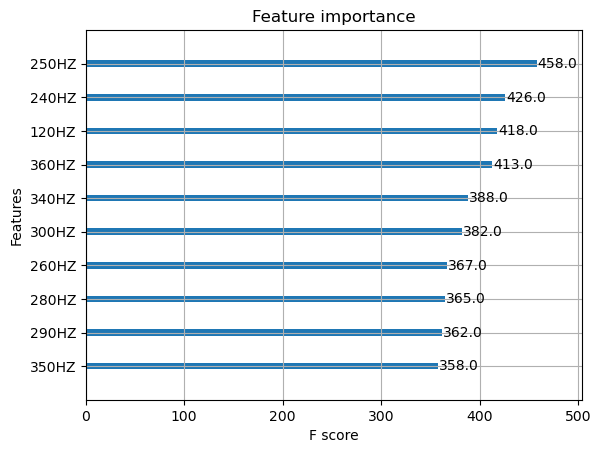

In [29]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=10)  # 상위 10개
plt.show()